# Simulation of a TFIM quench

In [1]:
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation
from pulser.waveforms import BlackmanWaveform, RampWaveform
from pulser.devices import MockDevice

import numpy as np
import qutip
import matplotlib.pyplot as plt

Let us study a simple one-dimensional system with periodic boundary conditions (a ring of atoms). 

After preparing an FM state (all up), we quench the system to a finite transverse and longitudinal field for a time t until measuring in the Z basis.

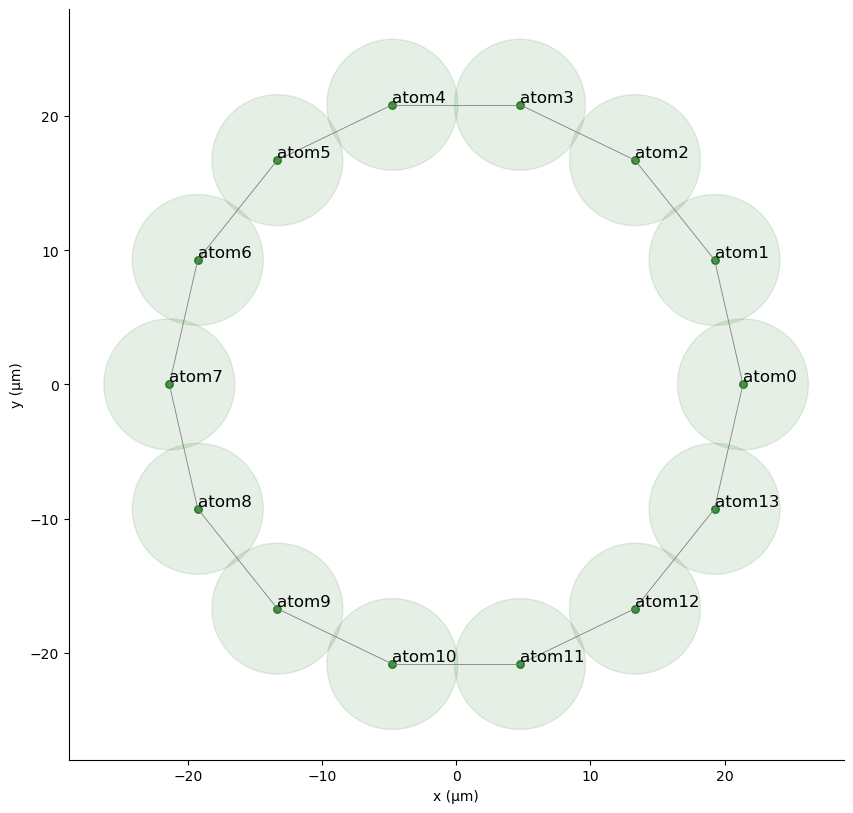

In [2]:
# Setup
L = 14

Omega_max = 2.3 * 2 * np.pi
U = Omega_max / 2.3

delta_0 = -3 * U
delta_f = 1 * U

t_rise = 500
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 5000

# Define a ring of atoms distanced by a blockade radius distance:
R_interatomic = MockDevice.rydberg_blockade_radius(U)
coords = (
    R_interatomic
    / (2 * np.tan(np.pi / L))
    * np.array(
        [
            (np.cos(theta * 2 * np.pi / L), np.sin(theta * 2 * np.pi / L))
            for theta in range(L)
        ]
    )
)

reg = Register.from_coordinates(coords, prefix="atom")

reg.draw(blockade_radius=R_interatomic, draw_half_radius=True, draw_graph=True)

We use the drawing capabilites of the `Register` class to highlight the area **half** the blockade radius away from each atom, which makes it so that overlapping circles correspond to interacting atoms. This is further fleshed out by the graph edges drawn using the `draw_graph` option.

In this register, we shall act with the following pulser sequence, which is designed to reach a state with *antiferromagnetic order*:

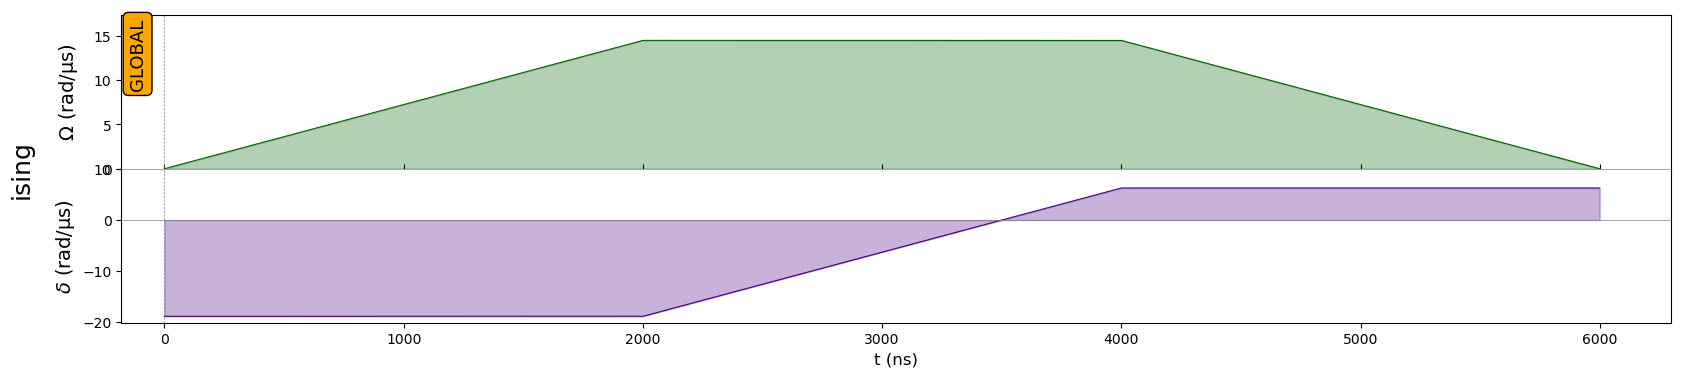

In [4]:
#constant detuning at delta_0
#Ramp for the rabi frequency, over t_rise, from 0 to Omega_max
rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
#constant amplitude at Omega_max, 
#Apply a Ramp on the detuning from delta_0 to delta_f
sweep = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
#constant detuning at delta_f
#ramp down from omega_max to 0
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)
#no phase over any of them

seq = Sequence(reg, MockDevice)
seq.declare_channel("ising", "rydberg_global") 
#declared on the rydberg-global, i.e. pulses are register wide, no need to target them

seq.add(rise, "ising")
seq.add(sweep, "ising")
seq.add(fall, "ising")

seq.draw()

## 1. Running a Simulation

First we define our `Simulation` object, which creates an internal respresentation of the quantum system, including the Hamiltonian which will drive the evolution:

In [5]:
sim = Simulation(seq, sampling_rate=0.1)

Notice we have included the parameter `sampling_rate` which allows us to determine how many samples from the pulse sequence we wish to simulate. In the case of the simple shapes in our sequence, only a very small fraction is needed. This largely accelerates the simulation time in the solver.

To run the simulation we simply apply the method `run()`. At the time of writing of this notebook, the method uses a series of routines from **QuTiP** for solving the Schröedinger equation of the system. It returns a `SimulationResults` object, which will allow the study or post-processing of the states for each time step in our simulation. Additionally, we can include a progress bar to have an estimate of how the simulation is advancing:

In [6]:
results = sim.run(progress_bar=True)

10.0%. Run time:   1.65s. Est. time left: 00:00:00:14
20.0%. Run time:   2.82s. Est. time left: 00:00:00:11
30.0%. Run time:   4.38s. Est. time left: 00:00:00:10
40.0%. Run time:   6.86s. Est. time left: 00:00:00:10
50.0%. Run time:   9.59s. Est. time left: 00:00:00:09
60.0%. Run time:  12.77s. Est. time left: 00:00:00:08
70.0%. Run time:  16.17s. Est. time left: 00:00:00:06
80.0%. Run time:  19.69s. Est. time left: 00:00:00:04
90.0%. Run time:  23.37s. Est. time left: 00:00:00:02
Total run time:  26.18s


## 2. Using the `SimulationResults` object

In [10]:
results.get_final_state()

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (16384, 1), type = ket
Qobj data =
  (0, 0)	(-1.8226688190638231e-07+2.1785354869536184e-08j)
  (1, 0)	(3.2365428486822184e-07+1.2886580008173897e-06j)
  (2, 0)	(3.236542848833265e-07+1.2886580008275333e-06j)
  (3, 0)	(-5.292911587957278e-07-1.6593652291470247e-06j)
  (4, 0)	(3.236542848609402e-07+1.2886580007974105e-06j)
  (5, 0)	(1.0300096817648093e-05-2.6884367179122914e-07j)
  (6, 0)	(-5.29291158812444e-07-1.6593652291314143e-06j)
  (7, 0)	(1.0284799284097679e-07+2.0114054010056005e-06j)
  (8, 0)	(3.2365428485826047e-07+1.2886580008243557e-06j)
  (9, 0)	(1.0084559924754418e-05-5.0432112756207004e-06j)
  (10, 0)	(1.0300096817649363e-05-2.6884367180333155e-07j)
  (11, 0)	(-1.3846995553830471e-05+2.135306021622246e-06j)
  (12, 0)	(-5.292911587858963e-07-1.6593652291472795e-06j)
  (13, 0)	(-1.3846995553818523e-05+2.1353060216224915e-06j)
  (14, 0)	(1.0284799280339637

The `SimulationResults` object that we created contains the quantum state at each time step. We can call them using the `states` attribute:

See https://pulser.readthedocs.io/en/stable/apidoc/simulation.html#simulation-results for info about the simulation results

In [11]:
results.states[23]  # Given as a `qutip.Qobj` object

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (16384, 1), type = ket
Qobj data =
  (0, 0)	(-7.805050027343672e-20+3.412907682653687e-20j)
  (1, 0)	(2.0688560318547774e-18-1.2918637148071066e-18j)
  (2, 0)	(2.0688560318547643e-18-1.2918637148071037e-18j)
  (3, 0)	(-4.124593192166986e-17+3.8384397539564337e-17j)
  (4, 0)	(2.0688560318547724e-18-1.2918637148071112e-18j)
  (5, 0)	(-5.454960296400216e-17+4.532333278879917e-17j)
  (6, 0)	(-4.124593192167002e-17+3.8384397539564355e-17j)
  (7, 0)	(7.623800453168567e-16-1.0480805773089866e-15j)
  (8, 0)	(2.0688560318547716e-18-1.2918637148071097e-18j)
  (9, 0)	(-5.300024404782545e-17+4.5276075057327777e-17j)
  (10, 0)	(-5.454960296400186e-17+4.5323332788799013e-17j)
  (11, 0)	(1.038327426843408e-15-1.2671557715547705e-15j)
  (12, 0)	(-4.1245931921669976e-17+3.83843975395643e-17j)
  (13, 0)	(1.0383274268434115e-15-1.267155771554771e-15j)
  (14, 0)	(7.623800453168546e-16-1

We can sample the final state directly, using the `sample_final_state()` method from the `SimulationResults` object. We try it with $1000$ samples and discard the less frequent bitstrings:

<BarContainer object of 35 artists>

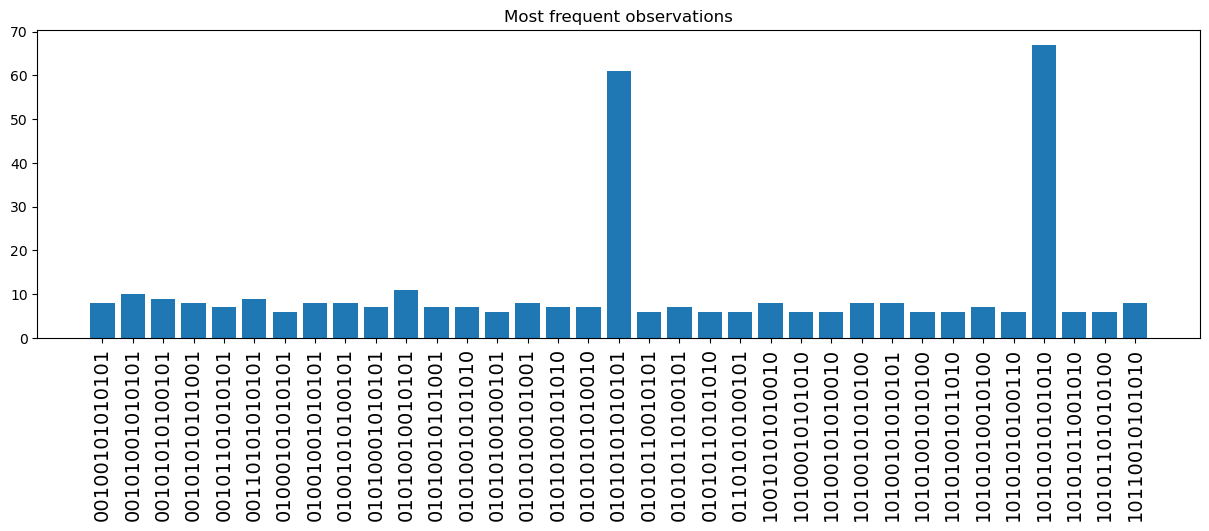

In [12]:
counts = results.sample_final_state(N_samples=1000)

large_counts = {k: v for k, v in counts.items() if v > 5}

plt.figure(figsize=(15, 4))
plt.xticks(rotation=90, fontsize=14)
plt.title("Most frequent observations")
plt.bar(large_counts.keys(), large_counts.values())

Notice how the most frequent bitstrings correspond to the antiferromagnetic order states.

We can also compute the expectation values of operators for the states in the evolution, using the `expect()` method, which takes a list of operators (in this case, the local magnetization acting on the $j$-th spin):

In [28]:
#this creates a magnetization operator
def magnetization(j, total_sites):
    prod = [qutip.qeye(2) for _ in range(total_sites)] #identity on all sites
    prod[j] = qutip.sigmaz() #put a sigma_z at site j
    return qutip.tensor(prod) #tensor product of all these operators


magn_list = [magnetization(j, L) for j in range(L)]

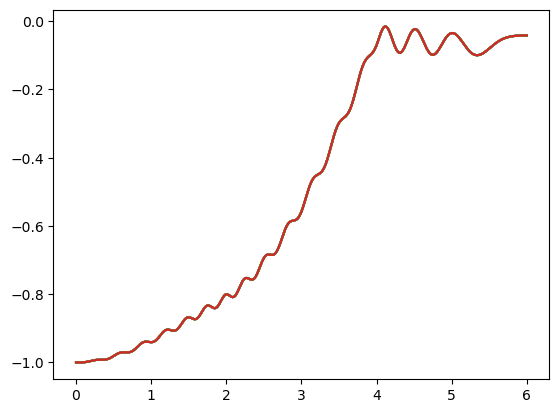

In [17]:
expect_magnetization = results.expect(magn_list) 
#feed an operator to the results (of N shots) and get expectation value
for data in expect_magnetization:
    plt.plot(sim.evaluation_times, data)

Notice how the local magnetization on *each* atom goes in the same way from $-1$ (which corresponds to the ground state) to $0$. This is expected since as we saw above, the state after the evolution has antiferromagnetic-order, so at each site, there is a compensation of magnetization. The parity (even) and the boundary conditions (periodic) allow for two lowest-energy states, whose superposition is similar to that of the perfectly antiferromagnetic state:  $\Big(|grgr\cdots \rangle + |rgrg\cdots \rangle\Big)/\sqrt{2}$

# Now - further investigations #

In [46]:
# Setup
L = 14

Omega_max = 2.3 * 2 * np.pi
U = Omega_max / 2.3

delta_0 = -3 * U
delta_f = 1 * U

t_rise = 20
t_fall = 20
t_sweep1 = (delta_f - 0) / (2 * np.pi * 10) * 100
t_sweep2 = (0 - delta_0) / (2 * np.pi * 10) * 100
t_pause = 6000 


# Define a ring of atoms distanced by a blockade radius distance:
R_interatomic = MockDevice.rydberg_blockade_radius(U)
coords = (
    R_interatomic
    / (2 * np.tan(np.pi / L))
    * np.array(
        [
            (np.cos(theta * 2 * np.pi / L), np.sin(theta * 2 * np.pi / L))
            for theta in range(L)
        ]
    )
)

reg = Register.from_coordinates(coords, prefix="atom")

#reg.draw(blockade_radius=R_interatomic, draw_half_radius=True, draw_graph=True)

In [41]:
t_pause

1960.0

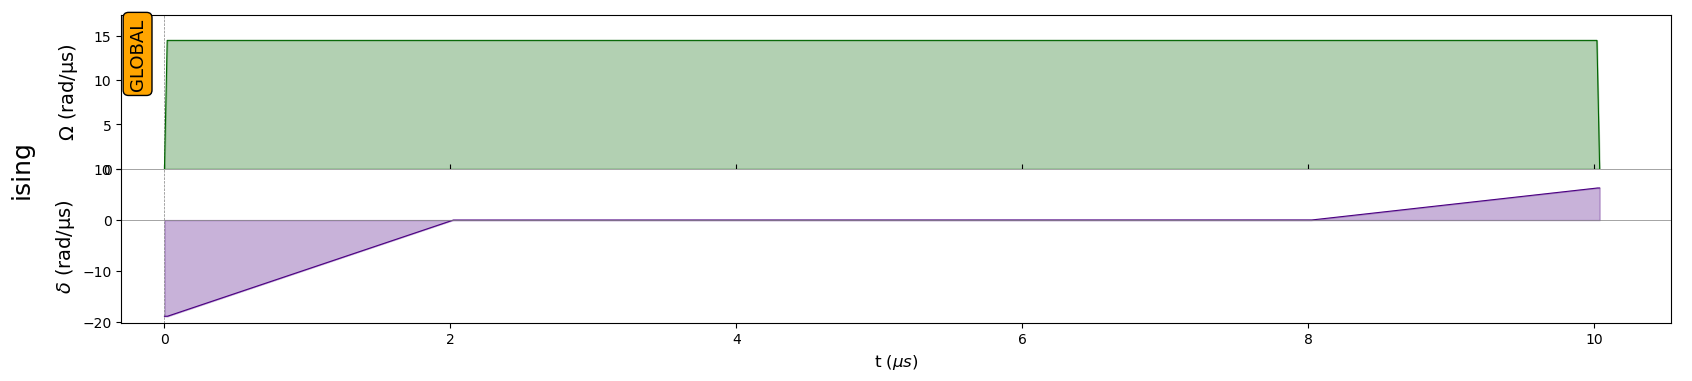

In [48]:
#constant detuning at delta_0
#Ramp for the rabi frequency, over t_rise, from 0 to Omega_max
rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
#constant amplitude at Omega_max, 
#Apply a Ramp on the detuning from delta_0 to delta_f
sweep1 = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, delta_0, 0), 0.0
)
pause = Pulse.ConstantPulse(t_pause, 
    Omega_max, 0.0, 0.0
)
sweep2 = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, 0, delta_f), 0.0
)
#constant detuning at delta_f
#ramp down from omega_max to 0
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)
#no phase over any of them

seq = Sequence(reg, MockDevice)
seq.declare_channel("ising", "rydberg_global") 
#declared on the rydberg-global, i.e. pulses are register wide, no need to target them

seq.add(rise, "ising")
seq.add(sweep1, "ising")
seq.add(pause, "ising")
seq.add(sweep2, "ising")
seq.add(fall, "ising")

seq.draw()

In [49]:
sim = Simulation(seq, sampling_rate=0.3)
results = sim.run(progress_bar=True)

10.0%. Run time:  10.43s. Est. time left: 00:00:01:33
20.0%. Run time:  21.89s. Est. time left: 00:00:01:27
30.0%. Run time:  38.59s. Est. time left: 00:00:01:29
40.0%. Run time:  55.69s. Est. time left: 00:00:01:23
50.0%. Run time:  70.51s. Est. time left: 00:00:01:10
60.0%. Run time:  84.63s. Est. time left: 00:00:00:56
70.0%. Run time: 100.76s. Est. time left: 00:00:00:43
80.0%. Run time: 114.69s. Est. time left: 00:00:00:28
90.0%. Run time: 130.19s. Est. time left: 00:00:00:14
Total run time: 146.12s


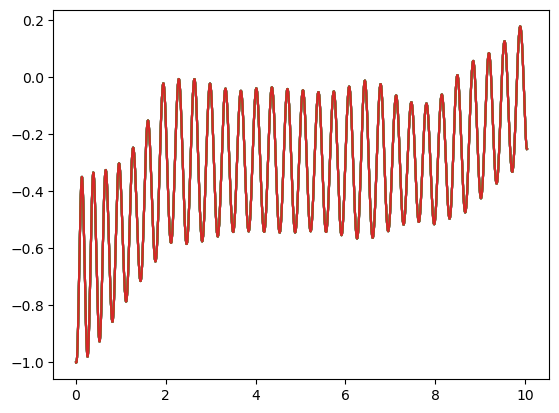

In [50]:
expect_magnetization = results.expect(magn_list) 
#feed an operator to the results (of N shots) and get expectation value
for data in expect_magnetization:
    plt.plot(sim.evaluation_times, data)